In [16]:

import numpy as np 
import pandas as pd 


# Data Loading

In [17]:
data = pd.read_csv("C:/Users/navee/Desktop/sikandar/FYP/ham10000/DATASET/hmnist_28_28_RGB.csv")

In [18]:
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [19]:
meta_df = pd.read_csv("C:/Users/navee/Desktop/sikandar/FYP/ham10000/DATASET/HAM10000_metadata.csv")
meta_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [20]:
meta_df.shape

(10015, 7)

In [21]:
data.shape

(10015, 2353)

In [22]:
yData = data['label']
XData = data.drop(columns = ['label'])

# EDA

In [23]:
distribution = meta_df['dx'].value_counts()
distribution

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [24]:
# classes = {4: ('nv', ' melanocytic nevi'),
#            6: ('mel', 'melanoma'),
#            2 :('bkl', 'benign keratosis-like lesions'), 
#            1:('bcc' , ' basal cell carcinoma'),
#            5: ('vasc', ' pyogenic granulomas and hemorrhage'),
#            0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
#            3: ('df', 'dermatofibroma')}

In [25]:
dist = data['label'].value_counts()
dist

4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: label, dtype: int64

**There's alot of data imbalance**

<Axes: >

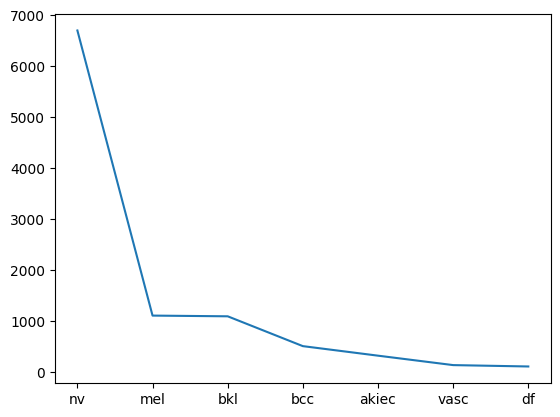

In [26]:
distribution.plot()

# Fixing Data Imbalance

* **over sample the dateset using Random Over Sampler**

In [28]:
from imblearn.over_sampling import RandomOverSampler 

In [29]:
sampler = RandomOverSampler()
XData,yData  = sampler.fit_resample(XData,yData)

In [30]:
XData.shape, yData.shape

((46935, 2352), (46935,))

In [31]:
XData = np.array(XData).reshape((-1, 28, 28, 3))
XData = XData / 255
XData.shape

(46935, 28, 28, 3)

# Create the train and validation set

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(XData,yData, test_size=0.2)

In [34]:
Xtrain.shape, Xtest.shape

((37548, 28, 28, 3), (9387, 28, 28, 3))

# Train the model

In [35]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import tensorflow as tf

img_width, img_height = 28,28


In [36]:
input_shape = (img_width, img_height, 3)

In [37]:
model = Sequential()
model.add(Conv2D(32, (2, 2), input_shape=input_shape))
model.add(Activation('swish'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (2, 2)))
model.add(Activation('swish'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (2, 2)))
model.add(Activation('swish'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('swish'))
model.add(Dropout(0.5))
model.add(Dense(7))
model.add(Activation('softmax'))


In [38]:
model.compile(loss='sparse_categorical_crossentropy',
optimizer='nadam',
metrics=['accuracy'])


In [39]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='skin.h5',
                                                  monitor='val_acc', mode='max',
                                                 verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [40]:
history = model.fit(Xtrain,
                    Ytrain,
                    epochs = 100,
                    validation_data = (Xtest, Ytest),
                    callbacks=[callback, early_stopping])

Epoch 1/100
1172/1174 [============================>.] - ETA: 0s - loss: 1.3754 - accuracy: 0.4553
Epoch 1: saving model to skin.h5
1174/1174 [==============================] - 32s 25ms/step - loss: 1.3749 - accuracy: 0.4556 - val_loss: 1.0853 - val_accuracy: 0.5867
Epoch 2/100
   1/1174 [..............................] - ETA: 37s - loss: 1.2819 - accuracy: 0.5312

C:\Users\navee\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1173/1174 [============================>.] - ETA: 0s - loss: 1.0390 - accuracy: 0.6009
Epoch 2: saving model to skin.h5
1174/1174 [==============================] - 28s 24ms/step - loss: 1.0392 - accuracy: 0.6009 - val_loss: 0.8795 - val_accuracy: 0.6596
Epoch 3/100
1174/1174 [==============================] - ETA: 0s - loss: 0.8830 - accuracy: 0.6646
Epoch 3: saving model to skin.h5
1174/1174 [==============================] - 29s 24ms/step - loss: 0.8830 - accuracy: 0.6646 - val_loss: 0.7535 - val_accuracy: 0.7190
Epoch 4/100
1174/1174 [==============================] - ETA: 0s - loss: 0.7668 - accuracy: 0.7062
Epoch 4: saving model to skin.h5
1174/1174 [==============================] - 31s 26ms/step - loss: 0.7668 - accuracy: 0.7062 - val_loss: 0.6517 - val_accuracy: 0.7458
Epoch 5/100
1173/1174 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.7359
Epoch 5: saving model to skin.h5
1174/1174 [==============================] - 31s 26ms/step - loss: 0.6928 - acc

In [41]:
import matplotlib.pyplot as plt

In [42]:
model.evaluate(Xtrain, Ytrain)

1174/1174 [==============================] - 11s 9ms/step - loss: 0.0322 - accuracy: 0.9903


[0.03219415619969368, 0.9902791380882263]

In [43]:
model.evaluate(Xtest, Ytest)

294/294 [==============================] - 3s 9ms/step - loss: 0.0887 - accuracy: 0.9733


[0.08866450190544128, 0.9732608795166016]

**PLEASE GIVE AN UPVOTE**

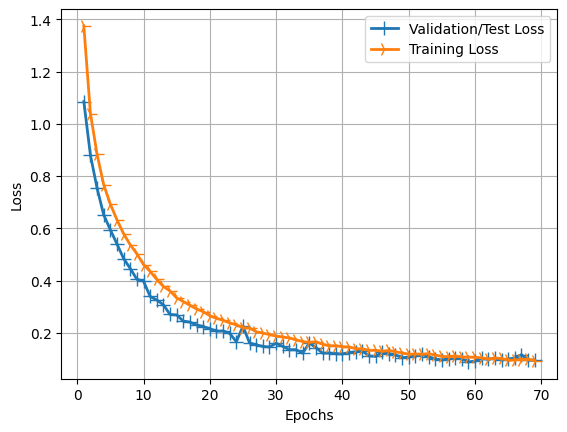

In [44]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

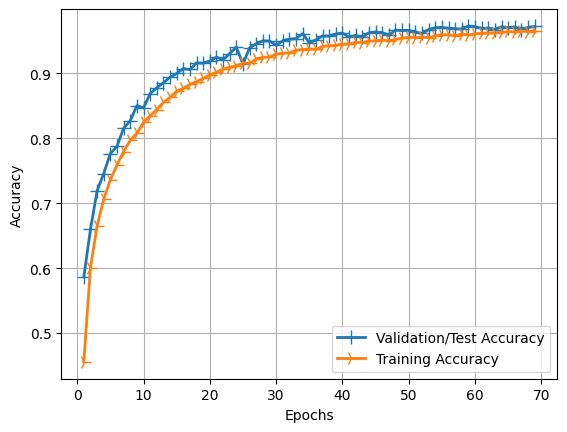

In [45]:
history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()